## Preparing Dataset & Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss,f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import KFold
import tqdm.notebook as tq

val_data = pd.read_csv('../data/val.csv',index_col = 'book_title')
train_data = pd.read_csv('../data/train.csv',index_col = 'book_title')

device = torch.device('cuda')

## Tokenized dataset

In [2]:
class bookDataset(Dataset):
    # for retrieving input IDs, attention mask, and token type ID, label and books detail
    def __init__(self,data, tokenizer, max_len, labels):
        self.tokenizer = tokenizer
        self.data = data
        self.book_details = list(data['book_details'])
        self.labels = self.data[labels].values
        self.max_len = max_len
        
    def __len__(self):
        return len(self.book_details)

    def __getitem__(self,index):
        book_desc = str(self.book_details[index])
        book_desc = " ".join(book_desc.split())
        inputs = self.tokenizer.encode_plus(
            book_desc,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding = 'max_length',
            return_token_type_ids= True,
            truncation = True,
            return_attention_mask =True,
            return_tensors = 'pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'labels': torch.FloatTensor(self.labels[index]),
            'book_details': book_desc
        }
        

In [3]:
max_length = 75 
cols_list = list(train_data.columns[1:]) #  label : Fantasy, Young Adult, Classics, Romance, dan Historical Fiction
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased") 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# set train and validation dataset
train_dataset = bookDataset(train_data, tokenizer,max_length,cols_list)
validation_dataset = bookDataset(val_data, tokenizer,max_length,cols_list)

In [5]:
# set the data loader
train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True,num_workers=4, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 32, shuffle = False, num_workers=4, pin_memory=True)

## Build Model BERT 1

In [6]:
class BERTModel(torch.nn.Module):
    def __init__(self):
        super(BERTModel, self).__init__()
        self.model = AutoModel.from_pretrained("google-bert/bert-base-uncased", return_dict=True)
        self.dropout1 = nn.Dropout(0.5)
        self.linear1 = nn.Linear(768, 312)
        
        self.dropout2 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(312, 128)

        self.dropout3 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(128, 5)

        self.leakyrelu = nn.LeakyReLU(negative_slope=0.015)
        self.bn1 = nn.BatchNorm1d(768)
        self.bn2 = nn.BatchNorm1d(312)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        output = output.last_hidden_state[:, 0, :]

        output = self.bn1(output) #num features : 768
        output = self.leakyrelu(output) # neg.slope : 0.015
        output = self.dropout1(output) # dropout : 50%
        output = self.linear1(output) # input : 768, output : 312
        
        output = self.bn2(output) #num features : 312
        output = self.leakyrelu(output)# neg.slope : 0.015
        output = self.dropout2(output) # dropout : 50%
        output = self.linear2(output) # input : 312, output : 128

        output = self.bn3(output) #num features : 128
        output = self.leakyrelu(output)# neg.slope : 0.015
        output = self.dropout3(output) # dropout : 50%
        output = self.linear3(output) # input : 128, output : 5
        
        return output
        
model = BERTModel()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [7]:
# early stopping
# Anticipate model overfitting scenario based on the score of the model, 
#  the model will stop the training process if the loss / score doesn't improve for a specified number of epochs
class EarlyStopping:  
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [8]:
# set optimizer, scheduler, error loss and early stopping
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=1e-5, weight_decay=1e-3) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0 = 6, T_mult = 1)
bce = nn.BCEWithLogitsLoss()

early_stopping = EarlyStopping(patience=5, delta=0.01)

In [9]:
# set training function and evaluation function
def train(loader, model, optimizer = optimizer , loss_fn = bce, scheduler = scheduler):
    # Trains a model using a data loader by iterating over batches, computing the loss, and updating the model’s weights. 
    # It uses mixed precision for efficiency, clips gradients to prevent exploding gradients, 
    # and adjusts the learning rate based on the average loss.
    loss_Li = []
    max_grad_norm = 0.5 
    
    model.train()
    for idx, data in enumerate(loader):
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        labels = data['labels'].to(device, dtype=torch.float)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output = model(ids, mask, token_type_ids)
            loss = loss_fn(output, labels)
            loss_Li.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
    scheduler.step(np.mean(loss_Li))
    
    return model, np.mean(loss_Li)

def eval(loader, model, loss_fn = bce):
    loss_Li = []
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(loader, 0):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            labels = data['labels'].to(device, dtype=torch.float)
            
            output = model(ids, mask, token_type_ids)
            loss = loss_fn(output, labels)
            loss_Li.append(loss.item())
            
    return  np.mean(loss_Li)

In [10]:
# build model fitting function 
def fitting(model, model_props, total_epochs):
    """
    Trains and validates a model over multiple epochs with early stopping.
    """
    histories = {metr : [] for metr in ['train_loss','val_loss']}

    train_loader, validation_loader = model_props['loader_list']
    optimizer = model_props['optimizer']
    loss_fn = model_props['loss_fn']
    scheduler = model_props['scheduler']
    early_stopping = model_props['early_stopping']
    
    
    for epoch in range(1,total_epochs+1):
        print('='*80)
        print(f'Epoch {epoch}/{total_epochs}')
        model, train_loss = train(train_loader, model,optimizer,loss_fn,scheduler)
        val_loss = eval(validation_loader, model,loss_fn)
    
        print(f'train loss : {train_loss}')
        print(f'validation loss : {val_loss}')
    
        histories['train_loss'].append(train_loss)
        histories['val_loss'].append(val_loss)
    
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return histories, model 

## Fitting model 

In [20]:
# model props : set data loader, optimizer, loss function, scheduler and early stopping for model
model_props = {
    'loader_list':[train_dataLoader,validation_dataloader],
    'optimizer':optimizer,
    'loss_fn':bce,
    'scheduler':scheduler,
    'early_stopping': early_stopping
}

histories , model = fitting(model,model_props, 30)

Epoch 1/30
train loss : 0.7061695147733219
validation loss : 0.6265919173465055
Epoch 2/30
train loss : 0.6163277065167662
validation loss : 0.5688852001638973
Epoch 3/30
train loss : 0.557444682668467
validation loss : 0.5160026927204693
Epoch 4/30
train loss : 0.5079871986733109
validation loss : 0.4918694724054897
Epoch 5/30
train loss : 0.4714046121620741
validation loss : 0.4588082809658611
Epoch 6/30
train loss : 0.4370067596435547
validation loss : 0.44181833810666027
Epoch 7/30
train loss : 0.40559151485318046
validation loss : 0.4053046431611566
Epoch 8/30
train loss : 0.3740337345443788
validation loss : 0.40190526930724874
Epoch 9/30
train loss : 0.3490706555178908
validation loss : 0.3879077715032241
Epoch 10/30
train loss : 0.3213541121756444
validation loss : 0.36934374097515554
Epoch 11/30
train loss : 0.3025454748360837
validation loss : 0.3760920333511689
Epoch 12/30
train loss : 0.28087251919214845
validation loss : 0.36248379595139446
Epoch 13/30
train loss : 0.26345

## Model evaluation

### Model 1

In [12]:
def get_eval_metrics(loader, model):
    y_pred = []
    y_labels = []
    
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(loader, 0):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            labels = data['labels'].to(device, dtype=torch.float)
            
            output = model(ids, mask, token_type_ids)
            y_pred_temp = (torch.sigmoid(output) > 0.5).int()

            y_labels.extend(labels.cpu().detach().numpy().tolist())
            y_pred.extend(y_pred_temp.cpu().detach().numpy().tolist())


    y_pred = np.array(y_pred)
    y_labels = np.array(y_labels)
    
    eval_result = {
        'hamming-loss' : hamming_loss(y_labels, y_pred),
        'precision' : precision_score(y_labels, y_pred, average='micro', zero_division=0),
        'recall' : recall_score(y_labels, y_pred, average='micro'),
        'f1-score' : f1_score(y_labels, y_pred, average='micro')
    }
            
    return  eval_result


In [25]:
val_eval_metrics = get_eval_metrics(validation_dataloader, model)

for metrics in val_eval_metrics : 
    print(f'{metrics} : {val_eval_metrics[metrics]}')

hamming-loss : 0.13394833948339482
precision : 0.7459190915542938
recall : 0.740662438336857
f1-score : 0.7432814710042435


Text(0.5, 1.0, 'loss learning curve')

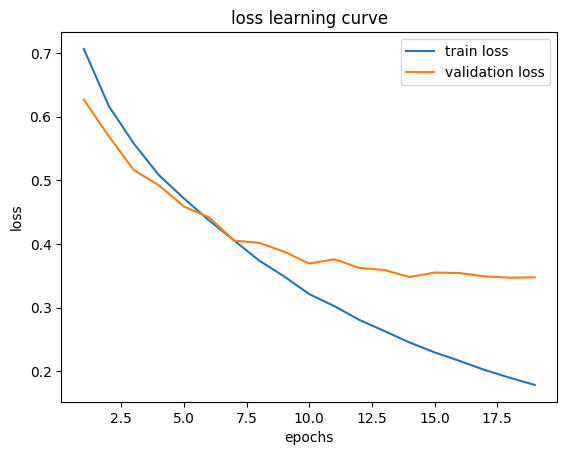

In [26]:
epochs = range(1,len(histories['train_loss']) + 1)
plt.plot(epochs, histories['train_loss'], label = 'train loss')
plt.plot(epochs, histories['val_loss'], label = 'validation loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss learning curve')

In [33]:
clear gpu ram device = cuda.select_device(1) device.reset()

## Build BERT model 2

### Hyperparameter tuning

In [13]:
import optuna
from sklearn.model_selection import KFold
from torch.utils.data import Subset

def reset_parameters(module):
    if hasattr(module, "reset_parameters"):
        module.reset_parameters()

def prepare_model(dict_params):
    model_trial =  BERTModel()
    model_trial.to(device)

    # Update the model dropout rates
    model_trial.dropout1.p,model_trial.dropout2.p,model_trial.dropout3.p = dict_params['dropout']
    
    optimizer = torch.optim.AdamW(params=model_trial.parameters(), lr=dict_params['lr'], weight_decay=dict_params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=6, T_mult=1)

    return model_trial,optimizer,scheduler
    
   
def objective(trial):
    # The hyperparameter tuning is used to find optimal model parameter based on given parameter options including learning rare, weight decay,
    # dropout rate. The process uses K-fold cross-validation on the training dataset to ensure the model generalizes well and performs consistently
    learning_rate = trial.suggest_float("lr", 1e-6, 1e-3)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2)
    
    dropout_rate_1 = trial.suggest_float("dropout_1", 0.1, 0.5)
    dropout_rate_2 = trial.suggest_float("dropout_2", 0.1, 0.5)
    dropout_rate_3 = trial.suggest_float("dropout_3", 0.1, 0.5)

    dict_params = {
        'lr':learning_rate,
        'weight_decay' : weight_decay,
        'dropout':[dropout_rate_1,dropout_rate_2,dropout_rate_3]
    }

    model_trial,optimizer,scheduler = prepare_model(dict_params)

    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    val_scores = []

    for train_index, val_index in kf.split(train_data):
        train_subset = bookDataset(train_data.iloc[train_index], tokenizer,max_length,cols_list)
        val_subset = bookDataset(train_data.iloc[val_index], tokenizer,max_length,cols_list)
        
        train_loader = DataLoader(train_subset, batch_size = 32, shuffle = True,num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_subset, batch_size = 32, shuffle = False,num_workers=4, pin_memory=True)
        early_stopping = EarlyStopping(patience=5, delta=0.01)
        
        model_props = {
            'loader_list':[train_loader,val_loader],
            'optimizer':optimizer,
            'loss_fn':bce,
            'scheduler':scheduler,
            'early_stopping': early_stopping
        }

        model_trial.apply(reset_parameters)

        histories, model_trial = fitting(model_trial,model_props,30)

        score = get_eval_metrics(val_loader, model_trial)['f1-score']

        val_scores.append(score)
    
    return sum(val_scores)/len(val_scores)
    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=7)

[I 2024-12-01 03:17:55,742] A new study created in memory with name: no-name-be0cdaaa-f910-47a5-80c6-ada0adc9f99a


Epoch 1/30
train loss : 0.6201872431180057
validation loss : 0.5838960742249208
Epoch 2/30
train loss : 0.5885680867176429
validation loss : 0.5824730834540199
Epoch 3/30
train loss : 0.5853586490539944
validation loss : 0.5878802409359053
Epoch 4/30
train loss : 0.5855398953837507
validation loss : 0.581033225737366
Epoch 5/30
train loss : 0.5834691793310876
validation loss : 0.5845500061324999
Epoch 6/30
train loss : 0.5824350133246067
validation loss : 0.5776232381661733
Early stopping
Epoch 1/30
train loss : 0.6173810082323411
validation loss : 0.6245915562498803
Epoch 2/30
train loss : 0.5885128625759891
validation loss : 0.5861072294852313
Epoch 3/30
train loss : 0.5837598746898127
validation loss : 0.5872150904992047
Epoch 4/30
train loss : 0.5829690173268318
validation loss : 0.5835594339113609
Epoch 5/30
train loss : 0.582922207958558
validation loss : 0.58222790471479
Epoch 6/30
train loss : 0.5814397202110758
validation loss : 0.5837832087395238
Epoch 7/30
train loss : 0.581

[I 2024-12-01 03:33:23,759] Trial 0 finished with value: 0.0 and parameters: {'lr': 0.00018643901634575818, 'weight_decay': 0.009544279055453107, 'dropout_1': 0.19047759743538803, 'dropout_2': 0.11487943748183711, 'dropout_3': 0.1337078147700846}. Best is trial 0 with value: 0.0.


Epoch 1/30
train loss : 0.6590668597057754
validation loss : 0.6322784686789793
Epoch 2/30
train loss : 0.6186413954870373
validation loss : 0.6201978781644035
Epoch 3/30
train loss : 0.6004879591511745
validation loss : 0.6191699335388109
Epoch 4/30
train loss : 0.5848835230458016
validation loss : 0.6049170792102814
Epoch 5/30
train loss : 0.5469527359978825
validation loss : 0.8260184730969223
Epoch 6/30
train loss : 0.5082509675446678
validation loss : 0.5413166725752401
Epoch 7/30
train loss : 0.47824019982534294
validation loss : 0.6705848148056105
Epoch 8/30
train loss : 0.45130788885495243
validation loss : 0.6543665557515388
Epoch 9/30
train loss : 0.42227785917473776
validation loss : 0.6825293916113236
Epoch 10/30
train loss : 0.3974409797320179
validation loss : 0.6954687635103861
Epoch 11/30
train loss : 0.37222850556467096
validation loss : 0.5404422248111052
Early stopping
Epoch 1/30
train loss : 0.67369590465929
validation loss : 0.6599370428160125
Epoch 2/30
train loss

[I 2024-12-01 03:57:16,598] Trial 1 finished with value: 0.1710113875332302 and parameters: {'lr': 4.3826098711172886e-05, 'weight_decay': 0.006039735374375998, 'dropout_1': 0.29156578140066963, 'dropout_2': 0.2557204927961215, 'dropout_3': 0.3206057705122194}. Best is trial 1 with value: 0.1710113875332302.


Epoch 1/30
train loss : 0.6011714615366038
validation loss : 0.5852077381283629
Epoch 2/30
train loss : 0.5896043000268001
validation loss : 0.576549262977114
Epoch 3/30
train loss : 0.5848937879006068
validation loss : 0.577551884394066
Epoch 4/30
train loss : 0.5843968651458329
validation loss : 0.5768693177139058
Epoch 5/30
train loss : 0.5824480546163577
validation loss : 0.5780904818983639
Epoch 6/30
train loss : 0.5825017304981456
validation loss : 0.5783520413964403
Early stopping
Epoch 1/30
train loss : 0.6058529909042751
validation loss : 0.5829844842938816
Epoch 2/30
train loss : 0.5850098968720904
validation loss : 0.588293703455551
Epoch 3/30
train loss : 0.5842071309977886
validation loss : 0.5821890892351375
Epoch 4/30
train loss : 0.5812170581490386
validation loss : 0.5833140944733339
Epoch 5/30
train loss : 0.579983057344661
validation loss : 0.5846421779955134
Epoch 6/30
train loss : 0.5796803015412069
validation loss : 0.5836270343439252
Early stopping
Epoch 1/30
tra

[I 2024-12-01 04:10:36,529] Trial 2 finished with value: 0.0 and parameters: {'lr': 0.0005854825186731833, 'weight_decay': 0.008878783604179314, 'dropout_1': 0.19339862932291083, 'dropout_2': 0.15257078028351395, 'dropout_3': 0.21138672874224018}. Best is trial 1 with value: 0.1710113875332302.


Epoch 1/30
train loss : 0.6005833743541849
validation loss : 0.579982637482531
Epoch 2/30
train loss : 0.5866054918836144
validation loss : 0.576593846374867
Epoch 3/30
train loss : 0.5833319653482998
validation loss : 0.5880892168657452
Epoch 4/30
train loss : 0.5830729105601123
validation loss : 0.5788923978221183
Epoch 5/30
train loss : 0.5824664877910241
validation loss : 0.576775936811578
Epoch 6/30
train loss : 0.5802584668877078
validation loss : 0.5767118667854982
Early stopping
Epoch 1/30
train loss : 0.5998643920117733
validation loss : 0.5915338706736472
Epoch 2/30
train loss : 0.5846477032584303
validation loss : 0.5832494053186155
Epoch 3/30
train loss : 0.5806015994326741
validation loss : 0.5999705379500109
Epoch 4/30
train loss : 0.5792633495202252
validation loss : 0.5867185995859259
Epoch 5/30
train loss : 0.5770764700045773
validation loss : 0.5849689581230575
Epoch 6/30
train loss : 0.5777831755432428
validation loss : 0.5840626604416791
Early stopping
Epoch 1/30
tr

[I 2024-12-01 04:23:54,548] Trial 3 finished with value: 0.0 and parameters: {'lr': 0.0008374734593366992, 'weight_decay': 0.004921939258315992, 'dropout_1': 0.12198074858962396, 'dropout_2': 0.196882575832288, 'dropout_3': 0.14666580364954018}. Best is trial 1 with value: 0.1710113875332302.


Epoch 1/30
train loss : 0.6350563253257789
validation loss : 0.6197703667715484
Epoch 2/30
train loss : 0.5900199774141405
validation loss : 0.5977709211555182
Epoch 3/30
train loss : 0.5880346751096202
validation loss : 0.6002250529971778
Epoch 4/30
train loss : 0.5842269025012559
validation loss : 0.5882041781556373
Epoch 5/30
train loss : 0.5843306427784994
validation loss : 0.5809959243325626
Epoch 6/30
train loss : 0.5842054461439451
validation loss : 0.577803738561331
Epoch 7/30
train loss : 0.5826771335274565
validation loss : 0.5772540756300384
Epoch 8/30
train loss : 0.5831052203680954
validation loss : 0.5800050117221534
Epoch 9/30
train loss : 0.5828011792664435
validation loss : 0.5773368962839538
Epoch 10/30
train loss : 0.5821971514937925
validation loss : 0.576483953817218
Early stopping
Epoch 1/30
train loss : 0.6239535931278678
validation loss : 0.6082147254663355
Epoch 2/30
train loss : 0.5866135922717113
validation loss : 0.5928254267748665
Epoch 3/30
train loss : 0.

[I 2024-12-01 04:44:28,782] Trial 4 finished with value: 0.0 and parameters: {'lr': 0.00018815961960099613, 'weight_decay': 0.005087025577508707, 'dropout_1': 0.4829355323587313, 'dropout_2': 0.49303912714929665, 'dropout_3': 0.15189029157299572}. Best is trial 1 with value: 0.1710113875332302.


Epoch 1/30
train loss : 0.6040904197622748
validation loss : 0.5806845449933818
Epoch 2/30
train loss : 0.5855826386341861
validation loss : 0.5802566677916283
Epoch 3/30
train loss : 0.5836057040621253
validation loss : 0.6027562501383763
Epoch 4/30
train loss : 0.5832806264652926
validation loss : 0.5785113912002713
Epoch 5/30
train loss : 0.5806878765716272
validation loss : 0.5783851362910926
Epoch 6/30
train loss : 0.5818389810475648
validation loss : 0.5809650234147614
Early stopping
Epoch 1/30
train loss : 0.6053838667039778
validation loss : 0.5875837697702295
Epoch 2/30
train loss : 0.5845629241244465
validation loss : 0.5928855444870743
Epoch 3/30
train loss : 0.5810642037905899
validation loss : 0.5861670053472706
Epoch 4/30
train loss : 0.5799461091850319
validation loss : 0.5852763696628458
Epoch 5/30
train loss : 0.5804480103885427
validation loss : 0.5955291840375638
Epoch 6/30
train loss : 0.5783055734400656
validation loss : 0.5873109560971167
Early stopping
Epoch 1/30

[I 2024-12-01 04:59:14,138] Trial 5 finished with value: 0.0 and parameters: {'lr': 0.0006150860448615532, 'weight_decay': 0.006274582186478437, 'dropout_1': 0.2098959310681844, 'dropout_2': 0.1168771733802616, 'dropout_3': 0.10093885554564297}. Best is trial 1 with value: 0.1710113875332302.


Epoch 1/30
train loss : 0.5999978934140766
validation loss : 0.5830757115401474
Epoch 2/30
train loss : 0.5872442099977943
validation loss : 0.5797965777855293
Epoch 3/30
train loss : 0.5841697423773653
validation loss : 0.5773811267287123
Epoch 4/30
train loss : 0.5839425369220621
validation loss : 0.5772372548486672
Epoch 5/30
train loss : 0.5829130250449274
validation loss : 0.5763731423546287
Epoch 6/30
train loss : 0.5824537963843813
validation loss : 0.5778067550238442
Early stopping
Epoch 1/30
train loss : 0.604627324523879
validation loss : 0.5862911057238486
Epoch 2/30
train loss : 0.5854701954944461
validation loss : 0.5857912816253363
Epoch 3/30
train loss : 0.5801447134684113
validation loss : 0.5831452993785634
Epoch 4/30
train loss : 0.5807284330036125
validation loss : 0.5881082859693789
Epoch 5/30
train loss : 0.5787818161588089
validation loss : 0.5882613346272824
Epoch 6/30
train loss : 0.5780723541975021
validation loss : 0.5824235356321522
Early stopping
Epoch 1/30


[I 2024-12-01 05:12:30,393] Trial 6 finished with value: 0.0 and parameters: {'lr': 0.0008514778088264743, 'weight_decay': 0.001329002581312112, 'dropout_1': 0.15260461245118778, 'dropout_2': 0.38030240233241264, 'dropout_3': 0.1933163164394579}. Best is trial 1 with value: 0.1710113875332302.


In [17]:
# best hyperparameter model and F1 score
print("Best Parameters:", study.best_params)
print("Best F1-Score:", study.best_value)

Best Parameters: {'lr': 4.3826098711172886e-05, 'weight_decay': 0.006039735374375998, 'dropout_1': 0.29156578140066963, 'dropout_2': 0.2557204927961215, 'dropout_3': 0.3206057705122194}
Best F1-Score: 0.1710113875332302


## Build Model 2

In [21]:
# build model using the best parameters on hyperparameter tuning
best_params = study.best_params
tuned_params = {
    'lr':best_params['lr'],
    'weight_decay' : best_params['weight_decay'],
    'dropout':[best_params['dropout_1'],best_params['dropout_2'],best_params['dropout_3']]
}

tuned_model,tuned_optimizer,tuned_scheduler = prepare_model(tuned_params)

In [22]:
# prepare data loader, optimizer, bce loss function, scheduler and early stopping for fitting model
early_stopping_2= EarlyStopping(patience=5, delta=0.01)

model_props_tuned = {
    'loader_list':[train_dataLoader,validation_dataloader],
    'optimizer':tuned_optimizer,
    'loss_fn':bce,
    'scheduler':tuned_scheduler,
    'early_stopping': early_stopping_2
}

# fitting model
histories_tuned , tuned_model = fitting(tuned_model,model_props_tuned, 30)

Epoch 1/30
train loss : 0.5261273702637094
validation loss : 0.41919466414872336
Epoch 2/30
train loss : 0.37150643497216895
validation loss : 0.3598088429254644
Epoch 3/30
train loss : 0.2901826573199913
validation loss : 0.3354518580086091
Epoch 4/30
train loss : 0.22373335542248898
validation loss : 0.3276001276338802
Epoch 5/30
train loss : 0.17531057803845795
validation loss : 0.3318660127765992
Epoch 6/30
train loss : 0.1405209122378318
validation loss : 0.335761902086875
Epoch 7/30
train loss : 0.11842538929376446
validation loss : 0.35299632303855
Epoch 8/30
train loss : 0.0991568666989686
validation loss : 0.36110607490820046
Early stopping


## Model Evaluation 

### Model 2

In [25]:
val_eval_metrics_tuned = get_eval_metrics(validation_dataloader, tuned_model)

for metrics in val_eval_metrics_tuned : 
    print(f'{metrics} : {val_eval_metrics_tuned[metrics]}')

hamming-loss : 0.13118081180811808
precision : 0.7521367521367521
recall : 0.7441860465116279
f1-score : 0.7481402763018066


Text(0.5, 1.0, 'loss learning curve')

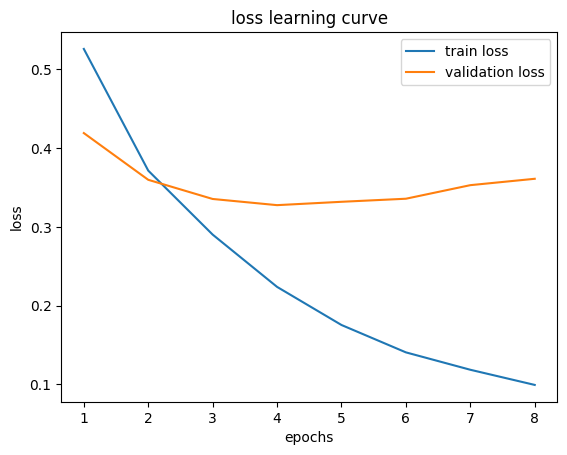

In [26]:
epochs = range(1,len(histories_tuned['train_loss']) + 1)
plt.plot(epochs, histories_tuned['train_loss'], label = 'train loss')
plt.plot(epochs, histories_tuned['val_loss'], label = 'validation loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('loss learning curve')